In [2]:
"""
Created on Tuesday 9 Feb 2023
Author: ZAW
"""
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from scipy.optimize import curve_fit
from scipy import signal
from tsmoothie.smoother import LowessSmoother
import csv

In [3]:
# Read dataset for a , b, c value
# data path
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/data.csv'
data_path = os.path.join(dirname,data_file)
data = pd.read_csv(data_path)

### Algorithms

In [163]:
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/two_deg.csv'
data_path = os.path.join(dirname,data_file)
# data = pd.read_csv(data_path)
data= pd.read_csv(data_path)

#### Test with different subjects

In [165]:
data_hc = data[['x1_PD001','y1_PD001']]
y_data = data_hc[data_hc.columns[0]]
x_data = data_hc[data_hc.columns[1]]

In [166]:
#plt.plot(y_data,x_data)

#### For stimulus

In [167]:
#import CSV data
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/2_degSti.xlsx'
data_path = os.path.join(dirname,data_file)
rawdata = pd.read_excel(data_path)
data_st = np.array(rawdata[1:],dtype=np.float)
time = data_st[:,1]
position = data_st[:,0]

/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_15287/1278966000.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_st = np.array(rawdata[1:],dtype=np.float)


In [168]:
# Trigonometric functions

# Define the function
def func(x, a, b, c):  #Position as a function of time.
    return a*(2/np.pi)*np.arcsin(np.sin(np.pi*(b*x+c)))

#initial guesses
#for 1 degree per second: [10, 0.05, 0]
#for 2 degrees per second: [10, 0.1, 0]
#for 4 degrees per second: [10, 0.2, 0]
#for 6 degrees per second: [10, 0.3, 0]
#for 8 degrees per second: [10, 0.4, 0]
InitialGuess = [10, 0.1, 0]

# Perform curve fitting
popt, pcov = curve_fit(func,position,time, p0=InitialGuess)

# Extract the optimal values of a, b, and c
a, b, c = popt
print("a =", a)
print("b =", b)
print("c =", c)

a = 9.989823272284305
b = 0.10000069841142097
c = -2.3002702245225147e-05


In [169]:
# # # # Trigonometric functions

# # # # Define the function
# # # def func(x, a, b, c):  #Position as a function of time.
# # #     return a*(2/np.pi)*np.arcsin(np.sin(np.pi*(b*x+c)))

# # # # drop NaN
# # # y_data = one_deg_time_eye.ffill()
# # # x_data = one_deg_pos_eye.ffill()

# # # y_data = one_deg_time_eye.bfill()
# # # x_data = one_deg_pos_eye.bfill()

# # # # # Example data points (x, y) - replace these with your actual data
# # # # x_data = np.array(one_deg_time_eye)
# # # # y_data = np.array(one_deg_pos_eye)


# # # #initial guesses
# # InitialGuess = [10, 0.05, 0]

# # # Perform curve fitting
# # popt, pcov = curve_fit(func, x_data, y_data, p0=InitialGuess)

# # # Extract the optimal values of a, b, and c
# # a, b, c = popt

# # print("Optimal values of a, b, and c:")
# print("a =", a)
# print("b =", b)
# print("c =", c)

In [170]:
# a = 10.19274
# b = 0.04942
# c = 0.00533

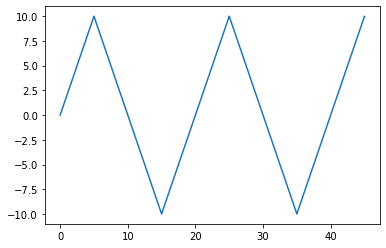

In [171]:
# Fit time
fit_time = func(y_data,a,b,c)
plt.plot(y_data,fit_time)
plt.show()

In [172]:
# Different(aka residual)
diff = x_data - fit_time

In [173]:
# Smooth residual
dt_array = np.array(diff)
dt_array = pd.DataFrame(dt_array,columns=['diff'])
window_size = 5
dt_array['Moving_Average'] = dt_array['diff'].rolling(window=window_size).mean()

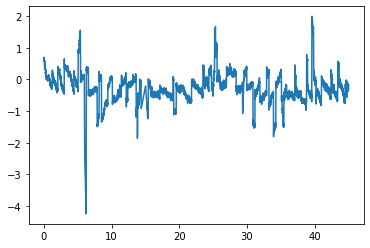

In [174]:
plt.plot(y_data,dt_array['Moving_Average'])

In [175]:
# create dataframe
data = {'Time':y_data,'POS':dt_array['Moving_Average']}
df = pd.DataFrame(data)

#### Choping the data

In [176]:
# Plot specific range
x_start = 5
x_end = 50

# Filter the data points within the disired range using boolean indexing
mask = (df['Time'] >= x_start) & (df['Time'] <= x_end)
x_data_range = df.loc[mask]
#y_data_range = y_data[mask]

# create plot


#plt.plot(x_data_range['Time'],x_data_range['POS'])

#### From start to end data

In [177]:
# x_data_range = df

In [178]:
# Test 20 point
data = {'Time':x_data_range['Time'],'POS':x_data_range['POS']}
df_test = pd.DataFrame(data)

In [179]:
# Determine the integration window
def check_sign(x):
    if x > 0:
        return "Positive"
    else:
        return "Negative"
df_test['Sign'] = df_test['POS'].apply(check_sign)

In [180]:
# Condition window width 
def calculate_start_end(row):
    global last_positive, last_negative
    if row['Sign'] == 'Positive':
        if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Positive':
            last_positive = row['Time']
            return last_positive, '', '', ''
        elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Positive':
            pos_end = row['Time']
            last_positive = ''
            return '', pos_end, '', ''
        else:
            return '', '', '', ''
    elif row['Sign'] == 'Negative':
        if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Negative':
            last_negative = row['Time']
            return '', '', last_negative, ''
        elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Negative':
            last_negative = row['Time']
            return '', '', '', last_negative
        else:
            return '', '', '', ''
    else:
        return '', '', '', ''

# Initialize the last positive and negative values to empty strings 
last_positive = ''
last_negative = ''

# Reset the index of the DataFrame
df_test = df_test.reset_index(drop=True)

# Apply the custom function to create new columns
df_test['PosTim_Start'], df_test['PosTim_End'], df_test['NegTim_Start'], df_test['NegTim_End'] = zip(*df_test.apply(calculate_start_end, axis=1))

# Fill the empty cells with an empty string
df_test['PosTim_Start'] = df_test['PosTim_Start'].fillna('') 
df_test['PosTim_End'] = df_test['PosTim_End'].fillna('')
df_test['NegTim_Start'] = df_test['NegTim_Start'].fillna('')
df_test['NegTim_End'] = df_test['NegTim_End'].fillna('')

# Print the resulting dataframe 
#print(df_test)

#### Positive Time Start Trimming

In [181]:
# Select the non-empty values in the 'Pos_Start' column
pos_start_values = df_test.loc[df_test['PosTim_Start'] != '', 'PosTim_Start'].values

# Round the values in the 'Pos_Start' column to two decimal places
rounded_pos_start_values = []
for value in pos_start_values:
    rounded_pos_start_values.append(round(value - 0.003, 2))

# Convert the list of rounded values back to a NumPy array
postim_start_values = np.array(rounded_pos_start_values)

# Print the non-empty values
print(postim_start_values)

[ 5.04  5.4   5.48  5.56  6.24  8.15  8.2   8.21  8.23  8.35  8.47  8.48
  9.73  9.76  9.78  9.8   9.8   9.85  9.89  9.9  10.   10.01 10.04 10.05
 10.08 11.44 11.58 11.88 11.95 11.96 12.   12.   13.11 13.15 13.26 13.31
 13.36 13.4  13.45 13.45 13.48 13.52 14.13 15.41 19.07 19.1  19.13 19.14
 21.89 22.11 23.48 23.79 23.89 23.98 24.   24.15 24.37 25.07 25.08 25.09
 25.59 25.62 25.66 25.83 25.87 25.96 26.88 26.97 29.54 29.57 31.83 32.89
 34.59 34.62 34.65 34.68 34.69 34.71 34.77 37.06 38.8  39.57 39.88 39.89
 40.   40.04 40.07 40.09 40.12 40.12 41.01 41.07 42.42 43.41 43.71]


#### Poisitive Time end Trimming

In [182]:
# Select the non-empty values in the 'Pos_End' column
pos_end_values = df_test.loc[df_test['PosTim_End'] != '', 'PosTim_End'].values

# Round the values in the 'Pos_End' column to two decimal places
rounded_pos_end_values = []
for value in pos_end_values:
    rounded_pos_end_values.append(round(value - 0.02, 2))

# Convert the list of rounded values back to a NumPy array
postim_end_values = np.array(rounded_pos_end_values)

# Print the non-empty values
print(postim_end_values)

[ 5.37  5.42  5.51  5.93  6.54  8.15  8.2   8.32  8.45  9.72  9.76  9.81
  9.86  9.98  9.99 10.02 10.03 10.07 11.44 11.56 11.87 11.93 12.12 13.1
 13.15 13.26 13.33 13.38 13.42 13.49 13.59 19.07 19.09 19.11 23.66 23.78
 23.87 23.98 24.02 24.74 25.05 25.07 25.56 25.6  25.62 25.78 25.85 25.93
 25.95 28.37 29.54 29.95 31.81 33.22 34.58 34.61 34.66 34.67 34.74 35.04
 37.22 38.94 39.86 39.96 39.99 40.05 40.06 40.12 41.01 41.06 42.59 43.61
 43.7 ]


In [183]:
# # Read the dataset again
# path = os.getcwd()
# dirname = os.path.dirname(path)
# data_file = 'data/raw_pd0013_1.xlsx'
# data_path = os.path.join(dirname,data_file)
# # data = pd.read_csv(data_path)
# data= pd.read_excel(data_path)

In [184]:
# Rename columns
data = data_hc.rename(columns={data_hc.columns.values[0]:"Position",
                               data_hc.columns.values[1]:'Time'})

#### Map the start positive Time to POS in raw data

In [185]:
# Create a dictionary from the mapping list
mapping_list = postim_start_values

# Map the values to the 'POS' column in raw
mapped_posSt = data.loc[data['Position'].isin(mapping_list),'Time']
mapped_posSt

1511     9.9798
1619     9.2137
1643     9.1935
1667     8.9919
1871     7.6949
          ...  
12302    2.2177
12320    2.3185
12725    5.1815
13022    7.6411
13112    7.2984
Name: Time, Length: 91, dtype: float64

#### Map the End positive Time to POS in raw data

In [186]:
# Create a dictionary from the mapping list
mapping_list = postim_end_values

# Map the values to the 'POS' column in raw
mapped_posEnd = data.loc[data['Position'].isin(mapping_list),'Time']
mapped_posEnd


1610     10.7460
1625      9.1935
1652      9.0524
1778      8.2863
1961      7.2379
          ...   
12302     2.2177
12317     2.0766
12776     5.5242
13082     7.5403
13109     7.2984
Name: Time, Length: 73, dtype: float64

In [187]:
# postim_start_values = [1, 2, 3,4,5,6]  # Length 100
# mapped_posSt = [1, 2, 3,4]         # Length 80

# # Check lengths and truncate longer column 
# if len(postim_start_values) > len(mapped_posSt): 
#     postim_start_values = postim_start_values[:len(mapped_posSt)]  # Truncate to 80
# elif len(mapped_posSt) > len(postim_start_values):
#     mapped_posSt = mapped_posSt[:len(postim_start_values)]      # Truncate to 100

# # Construct DataFrame    
# data_param = {'positive_x1':postim_start_values,'positive_y1':mapped_posSt}       
# param_gain_start = pd.DataFrame(data_param)

#### Velocity param positive dataframe

In [188]:
# # column miss match
# Check lengths and truncate longer column 
if len(postim_start_values) > len(mapped_posSt): 
    postim_start_values = postim_start_values[:len(mapped_posSt)] 
elif len(mapped_posSt) > len(postim_start_values):
    mapped_posSt = mapped_posSt[:len(postim_start_values)]      

# Now columns have equal length 
data_param = {'positive_x1':postim_start_values,'positive_y1':mapped_posSt}             
param_vel_start = pd.DataFrame(data_param)

data_param= {'positive_x2':postim_end_values,'positive_y2':mapped_posEnd}
param_vel_end = pd.DataFrame(data_param)

# Reset the indices of the DataFrames
param_vel_start = param_vel_start.reset_index(drop=True)
param_vel_end = param_vel_end.reset_index(drop=True)

# Concatenate the DataFrames horizontally
param_vel_positive_final = pd.concat([param_vel_start,param_vel_end],axis=1)
param_vel_positive_final['Del_X'] = param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1']

# Remove short duration for 50 to 70
param_vel_positive_final = param_vel_positive_final[(param_vel_positive_final['Del_X'] > 0.3) & 
                                                    (param_vel_positive_final['Del_X'] < 2.07)]
#param_vel_positive_final = param_vel_positive_final[param_vel_positive_final['Del_X'] < 2.07]
#                                                     (param_vel_positive_final['Del_X'] < 2.07)]

#param_vel_positive_final = param_vel_positive_final.fillna(method='ffill')
#param_gain_final
param_vel_positive_final


,positive_x1,positive_y1,positive_x2,positive_y2,Del_X
0,5.04,9.9798,5.37,10.7460,0.33
3,5.56,8.9919,5.93,8.2863,0.37
9,8.35,3.3468,9.72,0.5040,1.37
10,8.47,3.0444,9.76,0.5847,1.29
11,8.48,3.0040,9.81,0.4435,1.33
18,9.89,0.1613,11.44,-2.6210,1.55
19,9.90,0.0605,11.56,-3.2863,1.66
20,10.00,0.0202,11.87,-3.7500,1.87
21,10.01,-0.1815,11.93,-3.9113,1.92
25,11.44,-3.0242,13.26,-6.4516,1.82


In [189]:
param_vel_positive_final['Del_X'].sum()

21.349999999999998

In [190]:
param_vel_positive_final.head(40)

,positive_x1,positive_y1,positive_x2,positive_y2,Del_X
0,5.04,9.9798,5.37,10.7460,0.33
3,5.56,8.9919,5.93,8.2863,0.37
9,8.35,3.3468,9.72,0.5040,1.37
10,8.47,3.0444,9.76,0.5847,1.29
11,8.48,3.0040,9.81,0.4435,1.33
18,9.89,0.1613,11.44,-2.6210,1.55
19,9.90,0.0605,11.56,-3.2863,1.66
20,10.00,0.0202,11.87,-3.7500,1.87
21,10.01,-0.1815,11.93,-3.9113,1.92
25,11.44,-3.0242,13.26,-6.4516,1.82


#### Conditions

In [191]:
param_vel_positive_final['Condition'] = param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1']
param_vel_positive_final['Condition'] =abs(param_vel_positive_final['Condition'])
param_vel_positive_final = param_vel_positive_final[param_vel_positive_final['Condition'] > 0.72]

In [192]:
param_vel_positive_final['Del_X'].sum()

20.650000000000002

### Velocity for Positive peak calculation

In [193]:
# Calculate the difference between y2 and y1 divided by the difference between x2 and x1
param_vel_positive_final['slope'] = (param_vel_positive_final['positive_y2'] - param_vel_positive_final['positive_y1']) / (param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1'])

# abs
param_vel_positive_final['slope'] = abs(param_vel_positive_final['slope'])

# Reindexing
param_vel_positive_final = param_vel_positive_final.reset_index(drop=True)

# Remove unwant values
#param_gain_positive_final.loc[param_gain_positive_final['slope'] > 1.09, 'slope'] = np.nan  

# Calculate the average slope
average_positive_slope = abs(param_vel_positive_final['slope'].mean())

# Print the average slope
#print(average_positive_slope)

/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_15287/725332997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_vel_positive_final['slope'] = (param_vel_positive_final['positive_y2'] - param_vel_positive_final['positive_y1']) / (param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1'])
/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_15287/725332997.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_vel_positive_final['slope'] = abs(param_vel_po

In [194]:
#param_vel_positive_final = param_vel_positive_final[param_vel_positive_final['Del_X'] < 2]

In [195]:
param_vel_positive_final

,positive_x1,positive_y1,positive_x2,positive_y2,Del_X,Condition,slope
0,8.35,3.3468,9.72,0.5040,1.37,1.37,2.075036
1,8.47,3.0444,9.76,0.5847,1.29,1.29,1.906744
2,8.48,3.0040,9.81,0.4435,1.33,1.33,1.925188
3,9.89,0.1613,11.44,-2.6210,1.55,1.55,1.795032
4,9.90,0.0605,11.56,-3.2863,1.66,1.66,2.016145
5,10.00,0.0202,11.87,-3.7500,1.87,1.87,2.016150
6,10.01,-0.1815,11.93,-3.9113,1.92,1.92,1.942604
7,11.44,-3.0242,13.26,-6.4516,1.82,1.82,1.883187
8,11.58,-3.7298,13.33,-6.6734,1.75,1.75,1.682057
9,11.88,-3.8105,13.38,-6.7540,1.50,1.50,1.962333


In [196]:
# max_idx = param_vel_positive_final['slope'].idxmax()
# max_row = param_vel_positive_final.iloc[max_idx]
# max_row

#### Negative Time Start Trimming

In [197]:
# Select the non-empty values in the 'Pos_Start' column
neg_start_values = df_test.loc[df_test['NegTim_Start'] != '', 'NegTim_Start'].values

# Round the values in the 'Pos_Start' column to two decimal places
rounded_neg_start_values = []
for value in neg_start_values:
    rounded_neg_start_values.append(round(value - 0.003, 2))

# Convert the list of rounded values back to a NumPy array
negtim_start_values = np.array(rounded_neg_start_values)

# Print the non-empty values
print(negtim_start_values)

[ 5.    5.39  5.44  5.53  5.95  6.56  8.17  8.2   8.22  8.34  8.47  8.47
  8.48  9.74  9.78  9.79  9.8   9.83  9.88  9.89 10.   10.01 10.04 10.05
 10.06 10.09 11.46 11.58 11.89 11.95 11.96 12.   12.14 13.12 13.17 13.28
 13.35 13.4  13.44 13.45 13.46 13.51 13.61 14.13 15.42 19.09 19.11 19.13
 19.14 21.9  22.11 23.68 23.8  23.89 24.   24.04 24.15 24.76 25.07 25.09
 25.58 25.62 25.64 25.8  25.87 25.95 25.97 26.88 28.39 29.56 29.97 31.83
 33.24 34.6  34.63 34.65 34.68 34.69 34.76 35.06 37.24 38.96 39.88 39.88
 39.98 40.01 40.07 40.08 40.09 40.12 40.14 41.03 41.08 42.61 43.63 43.72]


#### Negative Time End Trimming

In [198]:
# Select the non-empty values in the 'Pos_Start' column
neg_end_values = df_test.loc[df_test['NegTim_End'] != '', 'NegTim_End'].values

# Round the values in the 'Pos_Start' column to two decimal places
rounded_neg_end_values = []
for value in neg_end_values:
    rounded_neg_end_values.append(round(value - 0.02, 2))

# Convert the list of rounded values back to a NumPy array
negtim_end_values = np.array(rounded_neg_end_values)

# Print the non-empty values
print(negtim_end_values)

[ 5.02  5.38  5.46  5.54  6.22  8.13  8.18  8.19  8.21  9.71  9.74  9.78
  9.83  9.88 10.06 11.42 11.56 11.86 11.93 11.94 11.98 13.09 13.13 13.24
 13.29 13.43 13.46 13.5  14.11 15.39 19.05 19.08 19.11 19.12 21.87 22.09
 23.46 23.77 23.87 23.96 24.13 24.35 25.05 25.07 25.57 25.64 25.81 25.94
 26.86 26.95 29.52 29.55 31.81 32.87 34.57 34.6  34.63 34.66 34.69 34.75
 37.04 38.78 39.55 39.98 40.02 40.07 40.1  40.99 41.05 42.4  43.39 43.69]


#### Map the start negative Time to POS in raw data

In [199]:
# Create a dictionary from the mapping list
mapping_list = negtim_start_values

# Map the values to the 'POS' column in raw
mapped_negSt = data.loc[data['Position'].isin(mapping_list),'Time']
mapped_negSt

1499     9.5363
1616     8.9113
1631     9.1331
1658     8.8105
1784     8.0645
          ...  
12308    2.0565
12323    2.1371
12782    5.1008
13088    6.9960
13115    7.5202
Name: Time, Length: 94, dtype: float64

#### Map the End of negative Time to POS in raw data

In [200]:
# Create a dictionary from the mapping list
mapping_list = negtim_end_values

# Map the values to the 'POS' column in raw
mapped_negEnd = data.loc[data['Position'].isin(mapping_list),'Time']
mapped_negEnd

1505      9.6371
1613     10.0202
1637      9.0121
1661      8.8710
1865      3.1855
          ...   
12296     1.4113
12314     2.0363
12719     4.2339
13016     6.3306
13106     7.2581
Name: Time, Length: 72, dtype: float64

#### Velocity param negative dataframe

In [201]:
# column miss match
# Check lengths and truncate longer column 
if len(negtim_start_values) > len(mapped_negSt): 
    negtim_start_values = negtim_start_values[:len(mapped_negSt)] 
elif len(mapped_negSt) > len(negtim_start_values):
    mapped_negSt = mapped_negSt[:len(negtim_start_values)]  


data_param = {'negative_x1':negtim_start_values,'negative_y1':mapped_negSt}             
param_vel_start = pd.DataFrame(data_param)
data_param= {'negative_x2':negtim_end_values,'negative_y2':mapped_negEnd}
param_vel_end = pd.DataFrame(data_param)

# Reset the indices of the DataFrames
param_vel_start = param_vel_start.reset_index(drop=True)
param_vel_end = param_vel_end.reset_index(drop=True)

# Concatenate the DataFrames horizontally
param_vel_negative_final = pd.concat([param_vel_start,param_vel_end],axis=1)
param_vel_negative_final['Del_X'] = param_vel_negative_final['negative_x2'] - param_vel_negative_final['negative_x1']
#param_vel_negative_final = param_vel_negative_final.fillna(method='ffill')
#param_vel_negative_final

# Remove short duration
# param_vel_negative_final = param_vel_negative_final[(param_vel_negative_final['Del_X'] > 0.3) & 
#                                                     (param_vel_negative_final['Del_X'] < 2.07)]


param_vel_negative_final = param_vel_negative_final[param_vel_negative_final['Del_X'] < 2.07]
#                                                     


In [202]:
param_vel_negative_final

,negative_x1,negative_y1,negative_x2,negative_y2,Del_X
0,5.00,9.5363,5.02,9.6371,0.02
1,5.39,8.9113,5.38,10.0202,-0.01
2,5.44,9.1331,5.46,9.0121,0.02
3,5.53,8.8105,5.54,8.8710,0.01
4,5.95,8.0645,6.22,3.1855,0.27
5,6.56,6.2702,8.13,2.7016,1.57
6,8.17,3.5484,8.18,3.6089,0.01
7,8.20,3.5887,8.19,3.6290,-0.01
8,8.22,3.4476,8.21,3.5685,-0.01
9,8.34,3.2661,9.71,0.5242,1.37


In [203]:
param_vel_negative_final['Del_X'].sum()

23.009999999999998

#### Conditions

In [204]:
param_vel_negative_final['Condition'] = param_vel_negative_final['negative_x2'] - param_vel_negative_final['negative_x1']
param_vel_negative_final['Condition'] =abs(param_vel_negative_final['Condition'])
param_vel_negative_final = param_vel_negative_final[param_vel_negative_final['Condition'] > 1.01]

### Velocity for Negative peak calculation

In [205]:
# Calculate the difference between y2 and y1 divided by the difference between x2 and x1
param_vel_negative_final['slope'] = (param_vel_negative_final['negative_y2']
                                     - param_vel_negative_final['negative_y1']) / (param_vel_negative_final['negative_x2'] 
                                     - param_vel_negative_final['negative_x1'])

# abs
param_vel_negative_final['slope'] = abs(param_vel_negative_final['slope'])

param_vel_negative_final['slope'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Reindexing
param_vel_negative_final = param_vel_negative_final.reset_index(drop=True)

# Remove unwant values
#param_gain_negative_final.loc[(param_gain_negative_final['slope'] < 0.80) |  
#                              (param_gain_negative_final['slope'] > 1.09), 
#                              'slope'] = np.nan
# Calculate the average slope
average_negative_slope = abs(param_vel_negative_final['slope'].mean())

# Print the average slope
print(average_negative_slope)

1.884825786684724


/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_15287/2067333518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_vel_negative_final['slope'] = (param_vel_negative_final['negative_y2']
/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_15287/2067333518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_vel_negative_final['slope'] = abs(param_vel_negative_final['slope'])
/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_15287/2067333518.py:9: SettingWithCopyWarning

In [206]:
# max_idx = param_vel_negative_final['slope'].idxmax()
# max_row = param_vel_negative_final.iloc[max_idx]
# max_row

In [207]:
param_vel_negative_final

,negative_x1,negative_y1,negative_x2,negative_y2,Del_X,Condition,slope
0,6.56,6.2702,8.13,2.7016,1.57,1.57,2.272994
1,8.34,3.2661,9.71,0.5242,1.37,1.37,2.001387
2,8.47,3.0444,9.74,0.4435,1.27,1.27,2.047953
3,8.47,3.0040,9.78,0.3024,1.31,1.31,2.062290
4,8.48,0.4435,9.83,0.3629,1.35,1.35,0.059704
5,9.79,0.4637,11.42,-3.2258,1.63,1.63,2.263497
6,9.80,0.3629,11.56,-3.2863,1.76,1.76,2.073409
7,9.83,0.2823,11.86,-3.9113,2.03,2.03,2.065813
8,9.88,0.3226,11.93,-3.9113,2.05,2.05,2.065317
9,9.89,0.0605,11.94,-3.7903,2.05,2.05,1.878439


In [208]:
#param_vel_negative_final = param_vel_negative_final[param_vel_negative_final['Del_X'] < 1.5]

In [209]:
param_vel_negative_final

,negative_x1,negative_y1,negative_x2,negative_y2,Del_X,Condition,slope
0,6.56,6.2702,8.13,2.7016,1.57,1.57,2.272994
1,8.34,3.2661,9.71,0.5242,1.37,1.37,2.001387
2,8.47,3.0444,9.74,0.4435,1.27,1.27,2.047953
3,8.47,3.0040,9.78,0.3024,1.31,1.31,2.062290
4,8.48,0.4435,9.83,0.3629,1.35,1.35,0.059704
5,9.79,0.4637,11.42,-3.2258,1.63,1.63,2.263497
6,9.80,0.3629,11.56,-3.2863,1.76,1.76,2.073409
7,9.83,0.2823,11.86,-3.9113,2.03,2.03,2.065813
8,9.88,0.3226,11.93,-3.9113,2.05,2.05,2.065317
9,9.89,0.0605,11.94,-3.7903,2.05,2.05,1.878439


In [210]:
Final_Vel = pd.concat([param_vel_positive_final[['Del_X','slope']],
                       param_vel_negative_final[['Del_X','slope']]], axis=0, join='outer')

In [211]:
Final_Vel

,Del_X,slope
0,1.37,2.075036
1,1.29,1.906744
2,1.33,1.925188
3,1.55,1.795032
4,1.66,2.016145
5,1.87,2.016150
6,1.92,1.942604
7,1.82,1.883187
8,1.75,1.682057
9,1.50,1.962333


In [212]:
Final_Vel['Checked_velocity'] = Final_Vel['slope'] * Final_Vel['Del_X']
Vel = Final_Vel['Checked_velocity'].sum()/Final_Vel['Del_X'].sum()
Vel

1.867766651141127

### Duration

In [213]:
Final_Vel['Del_X'].sum()

42.94

In [214]:
# total_vel = (average_positive_slope + average_negative_slope)/2


# total_vel

### Gain calculation

In [215]:
speed = 2
total_gain = Vel/speed
print("The gain for this subject is:",total_gain)

The gain for this subject is: 0.9338833255705635
